Importar Librerias


In [9]:
import sys
sys.path.append('./utils')
import pandas as pd
import numpy as np
import dataframe_gen as dg
import graficadores as gfr
import filtros as flt
import ext_coeficientes
import tensorflow as tf

import os
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")


Datasets a usar 


In [ ]:
ravdess = "./input/ravdess/"
crema = "./input/crema/"
tess = "./input/tess/"

Debido a las diferencias en el formato entregado para cada uno de nuestros datasets debemos generar un dataframe por separado para cada uno de los datasets que queremos usar, aunque nuestro objetivo sea entrenar nuestro modelo con los 3 a la vez

Dataframes

In [ ]:
df = pd.concat([dg.ravdess_df(ravdess), dg.crema_df(crema), dg.tess_df(tess)], axis=0)
df.to_csv("data.csv", index=False)

muestra = dg.df_muestra(df)
ruta = np.array(df.Ruta)[1]
data, sample_rate = librosa.load(ruta)

In [ ]:
# grafica la forma de onda para cada uno de los elementos de la muestra
def graficar_muestra(muestra):
    for emocion, ruta in zip(muestra.Emociones, muestra.Ruta):
        y, sr = librosa.load(ruta, duration=3)
        gfr.grafica(y, sr, emocion)

graficar_muestra(muestra)

In [ ]:

x = flt.noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [ ]:
if os.path.exists('coeficientes.csv'):
    Coeficientes = pd.read_csv('coeficientes.csv')
else:
    X, Y = [], []
    for ruta, Emocion in zip(df.Ruta, df.Emociones):
        feature = ext_coeficientes.get_features(ruta)
        for ele in feature:
            X.append(ele)
            Y.append(Emocion)
    Coeficientes = pd.DataFrame(X)
    Coeficientes['etiquetas'] = Y
    Coeficientes.to_csv('coeficientes.csv', index=False)

Coeficientes.head()


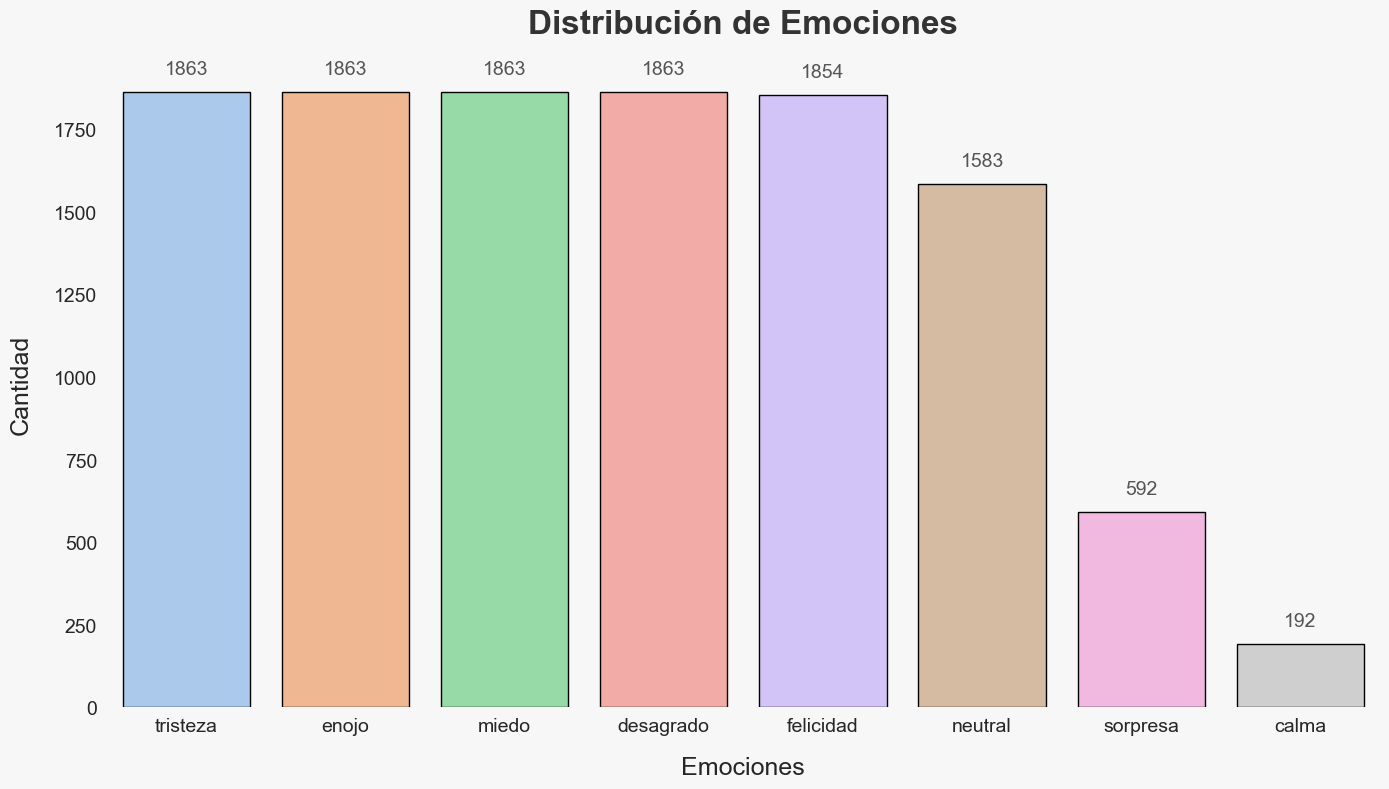

In [8]:
gfr.total_emociones(df)

GPUs disponibles: []


Proceso de entrenamiento del modelo

In [7]:
X = Coeficientes.iloc[:, :-1].values
Y = Coeficientes['etiquetas'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# hay que transformar nuestros datos para hacer el algoritmo.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

411/411 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.4970 - loss: 1.2581 - val_accuracy: 0.5214 - val_loss: 1.1958 - learning_rate: 0.0010
Epoch 6/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.5086 - loss: 1.2191 - val_accuracy: 0.5302 - val_loss: 1.1714 - learning_rate: 0.0010
Epoch 7/50
354/411 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5168 - loss: 1.2071

KeyboardInterrupt: 

In [ ]:
print("Evaluacion de precision : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(np.eye(pred_test.shape[1])[np.argmax(pred_test, axis=1)])

y_test_labels = encoder.inverse_transform(y_test)

df_Comparaciones = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_Comparaciones['Predicted Labels'] = y_pred.flatten()
df_Comparaciones['Actual Labels'] = y_test_labels.flatten()

df_Comparaciones.head(10)

In [ ]:
# Convert y_test from one-hot encoded format to label format
y_test_labels = encoder.inverse_transform(y_test)

cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_[0]] , columns = [i for i in encoder.categories_[0]])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicciones', size=14)
plt.ylabel('Etiquetas reales', size=14)
plt.show()

# Convert y_test from one-hot encoded format to label format
y_test_labels = encoder.inverse_transform(y_test)

print(classification_report(y_test_labels, y_pred))
